In [1]:
import os
import pandas as pd
import seaborn as sns
import requests
from googleapiclient.discovery import build

from dotenv import load_dotenv
load_dotenv()

True

## Find Channel IDs and Put Them Into a List

In [2]:
#Just a bit of setup for the project
api_key = os.environ.get('YOUTUBE_INSIGHTS_API_KEY')

channel_ids = ['UCAiLfjNXkNv24uhpzUgPa6A', #MrBeast Philanthropy
               'UCUaT_39o1x6qWjz7K2pWcgw', #Beast Reacts
               'UCgoFStVyEsm8tBZP5NC-aBQ', #MrBeast
               'UC4-79UOlP48-QNGgCko5p2g', #MrBeast 2
               'UCIPPMRA040LQr5QPyJEbmXA'  #MrBeast Gaming
               ]
         

channel_id = 'UCgoFStVyEsm8tBZP5NC-aBQ'
youtube = build('youtube', 'v3', developerKey=api_key)

In [3]:
# #MrBeast custom URL was returning values that weren't consistent with statistics on the channel page
# #Here I am attempting to extract the channel ID

# url = "https://www.googleapis.com/youtube/v3/channels"
# params = {
#     'part': 'snippet',
#     'forUsername': 'MrBeast',
#     'key': api_key
# }

# response = requests.get(url, params=params)


In [4]:

# Check the response status code to see if the request was successful
# if response.status_code == 200:
#     # If the request was successful, check if the 'items' key is in the response
#     if 'items' in response.json():
#         channel_id = response.json()['items'][0]['id']
#         print(channel_id)
#     else:
#         # If the 'items' key is not in the response, the channel may not have been found
#         print("The channel was not found.")
# else:
#     # If the request was unsuccessful, you may need to check the API key or URL
#     print("An error occurred while trying to retrieve the channel ID.")
 
##Channel ID still yielded values inconsistent with the channel page. I'll just have to work with what I've got for now

## Get Channel Statistics

In [32]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
        part = 'snippet, contentDetails, Statistics',
        id=','.join(channel_ids))
    response=request.execute()

    for item in response['items']:
        data = dict(Channel_Name = item['snippet']['title'],
                Subscribers = item['statistics']['subscriberCount'],
                Views = item['statistics']['viewCount'],
                Total_videos = item['statistics']['videoCount'],
                playlist_id = item['contentDetails']['relatedPlaylists']['uploads'])
        
        all_data.append(data)
    
    return all_data

In [33]:
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_statistics

[{'Channel_Name': 'MrBeast Gaming',
  'Subscribers': '31100000',
  'Views': '5471893383',
  'Total_videos': '138',
  'playlist_id': 'UUIPPMRA040LQr5QPyJEbmXA'},
 {'Channel_Name': 'Beast Philanthropy',
  'Subscribers': '11700000',
  'Views': '177874480',
  'Total_videos': '20',
  'playlist_id': 'UUAiLfjNXkNv24uhpzUgPa6A'},
 {'Channel_Name': 'MrBeast',
  'Subscribers': '1630',
  'Views': '67283',
  'Total_videos': '3',
  'playlist_id': 'UUgoFStVyEsm8tBZP5NC-aBQ'},
 {'Channel_Name': 'MrBeast 2',
  'Subscribers': '18900000',
  'Views': '2833245998',
  'Total_videos': '108',
  'playlist_id': 'UU4-79UOlP48-QNGgCko5p2g'},
 {'Channel_Name': 'Beast Reacts',
  'Subscribers': '21600000',
  'Views': '3287603708',
  'Total_videos': '232',
  'playlist_id': 'UUUaT_39o1x6qWjz7K2pWcgw'}]

In [7]:
channel_data = pd.DataFrame(channel_statistics)
channel_data

,Channel_Name,Subscribers,Views,Total_videos,playlist_id
0,MrBeast,1630,67283,3,UUgoFStVyEsm8tBZP5NC-aBQ
1,Beast Reacts,21600000,3287603708,232,UUUaT_39o1x6qWjz7K2pWcgw
2,MrBeast Gaming,31100000,5471893383,138,UUIPPMRA040LQr5QPyJEbmXA
3,MrBeast 2,18900000,2833245998,108,UU4-79UOlP48-QNGgCko5p2g
4,Beast Philanthropy,11700000,177874480,20,UUAiLfjNXkNv24uhpzUgPa6A


## Quick Visual Check of Channel Stats

In [8]:
channel_data['Channel_Name']= channel_data['Channel_Name'].astype(str)
channel_data['Subscribers']= channel_data['Subscribers'].astype('int64')
channel_data['Views']= channel_data['Views'].astype('int64')
channel_data['Total_videos']= channel_data['Total_videos'].astype('int64')

In [9]:
channel_data.sort_values(by='Subscribers', ascending=False, inplace=True)
channel_data.dtypes

Channel_Name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

Text(0, 0.5, 'Subscribers in Ten Millions')

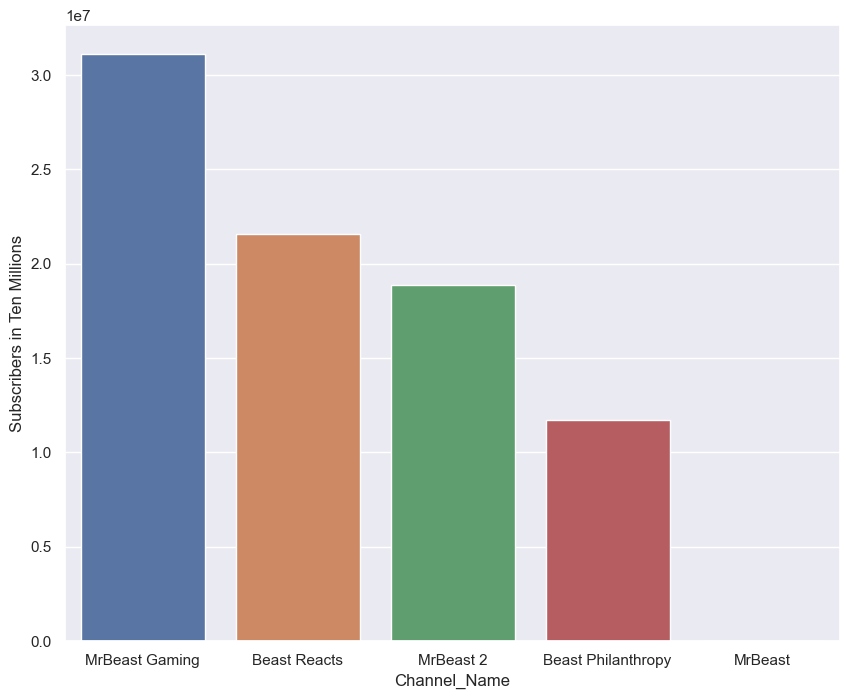

In [10]:
sns.set(rc={'figure.figsize':(10,8)})
channel_data.sort_values(by='Subscribers', ascending=False, inplace=False)
ax = sns.barplot(x='Channel_Name', y='Subscribers', data=channel_data)
ax.set_ylabel("Subscribers in Ten Millions")

Text(0, 0.5, 'Views in Billions')

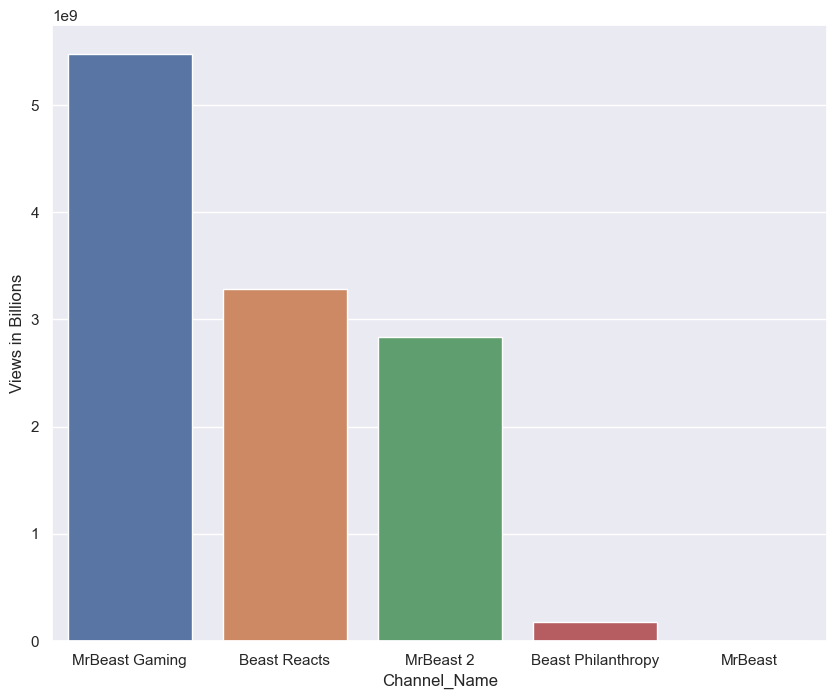

In [11]:
ax = sns.barplot(x='Channel_Name', y='Views', data=channel_data)
ax.set_ylabel("Views in Billions")

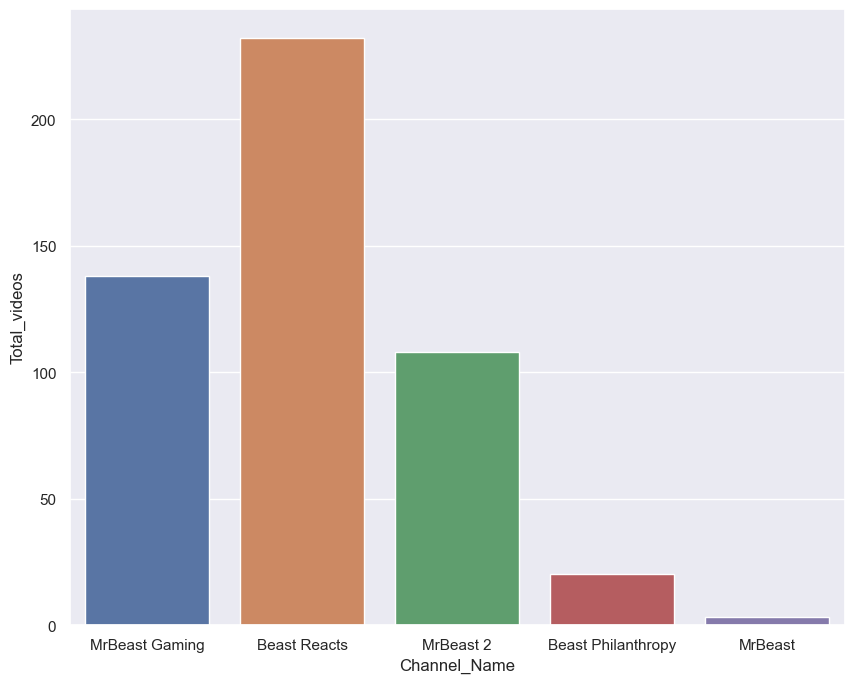

In [12]:
ax = sns.barplot(x='Channel_Name', y='Total_videos', data=channel_data)

In [13]:
channel_data

,Channel_Name,Subscribers,Views,Total_videos,playlist_id
2,MrBeast Gaming,31100000,5471893383,138,UUIPPMRA040LQr5QPyJEbmXA
1,Beast Reacts,21600000,3287603708,232,UUUaT_39o1x6qWjz7K2pWcgw
3,MrBeast 2,18900000,2833245998,108,UU4-79UOlP48-QNGgCko5p2g
4,Beast Philanthropy,11700000,177874480,20,UUAiLfjNXkNv24uhpzUgPa6A
0,MrBeast,1630,67283,3,UUgoFStVyEsm8tBZP5NC-aBQ


## Finding Video IDs

In [15]:
playlist_id = channel_data.loc[channel_data['Channel_Name'] == 'MrBeast Gaming', 'playlist_id'].iloc[0]

In [17]:
playlist_id

'UUIPPMRA040LQr5QPyJEbmXA'

In [20]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    next_page_token = None
    
    while True:
        request = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
        
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        if 'nextPageToken' not in response:
            break
        else:
            next_page_token = response['nextPageToken']
    
    return video_ids


In [25]:
# beast_gaming_ids = get_video_ids(youtube, playlist_id)
beast_gaming_ids

['RvYkeTmM1gc',
 'WkZHyBc3Xnc',
 'rncjTx-rRVc',
 '6T67I2w1G2U',
 'nyPcE29NNBU',
 'FKuLIrwIjt8',
 'nopEs-K4ExM',
 'qjoz-CAO3xQ',
 'mkKteoXE-X0',
 'JeTkMdw6RK8',
 'QO7e_RiMVQg',
 '1lIi1txDVzo',
 'IyEBRZsLZc8',
 'VWNdhuV6mwA',
 'rdsXcS4guLQ',
 'L678M0y86dw',
 'z2bcQBZyaY8',
 'Y3Lo33k4X44',
 's72dhTVYKtM',
 't2AB05DypWk',
 'APHXbkXHdy0',
 'VQY_m3wCBCE',
 'nJfVSMZzudk',
 'IPtpwh7r0Eo',
 'OF7SU-bm_IU',
 'dmNUwPxAuow',
 'jk6thMe6Vq8',
 '_euAXwajVis',
 'dLDj2TTyMGM',
 'hK6A_ebUKrM',
 'WLFEKf34a5U',
 '0QRTAwJoXuk',
 'HRdyfERwQZs',
 'iSvsf27wRns',
 'wnWbb3_U9Gc',
 'wW8FnNghyvI',
 'ABTdTTnnEU8',
 'Xqamnbm-ZLA',
 'FkVuYmRdI64',
 'eLSc9ZZ1UJI',
 'Z5TQBkJJlFE',
 '2O-9RmuiXog',
 'ZHxAkxGBUhc',
 'PwAMVSqP8_w',
 'ork4qET7pV0',
 'xwdhHTtc-3w',
 'OMAZB31W9nE',
 'SCrO3kS1upU',
 'w6byBDiL5gQ',
 'HrY_eDbF0XQ',
 'xN8ENrfE-TY',
 'c9C6t_nNouY',
 'hC3pyCvjy9E',
 'jl7whFSiE0Q',
 'ZNVlIMHS1sk',
 'gUeY3Crwpwo',
 'YaIh2sg2W-c',
 'qTolSU-2aXk',
 'vrUOPr9v8g4',
 'UcCJcV7S97c',
 'TU99gX7NGZ8',
 'WbIACyJPaH8',
 '2F0gws